# Runtime Monitoring Neuron Activation Patterns (1) - MNIST CNN

Start by fixing the random seed to ensure reproducability. In all our examples, we use 42. 

In [2]:
import numpy.random
# Fix the number for repeatability (we have also stored the trained model)
numpy.random.seed(42)


In [3]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import all required library, and set the device.

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import numpy as np
import h5py
import scipy.misc
import math
import matplotlib.pyplot as plt
from torch.autograd  import Variable
from torch.autograd.gradcheck import zero_gradients
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.models.inception import inception_v3

from PIL import Image
from scipy.misc import imsave
import os


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Define hyper-parameters. The parameter "sizeOfNeuronsToMonitor" is the number of neurons we will monitor, which is the 2nd to last layer. 

In [5]:
# Hyper-parameters 
num_classes = 10
num_epochs = 5
batch_size = 64
learning_rate = 0.001
sizeOfNeuronsToMonitor = 40

Then , prepare the training and test set. MNIST can be directly downloaded. Notice that we do not normalize the input data, but just rely on small learning rates. 

In [6]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='data/mnist', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data/mnist', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)



Define a utility function to display MNIST images. 

In [7]:
import util
    

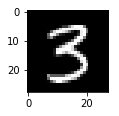

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

util.displayMNIST(images[0].numpy())


### Prepare the network 

To use run-time monitoring, apart from standard "forward()" function, we additionally define another function to return values of intermediate layers. 


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    
    def __init__(self):
        super(NeuralNet, self).__init__()
 
        self.conv1 = nn.Conv2d(1, 40, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(40, 20, 5)
        self.fc1 = nn.Linear(20 * 4 * 4, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80, sizeOfNeuronsToMonitor)
        self.fc4 = nn.Linear(sizeOfNeuronsToMonitor, num_classes)
        
    def forward(self, x):
        # Original 28x28x1 -(conv)-> 24x24x40 -(pool)-> 12x12x40
        x = self.pool(F.relu(self.conv1(x)))
        # Original 12x12x40 -(conv)-> 8x8x20 -(pool)-> 4x4x20
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten it to an array of inputs
        x = x.view(-1, 20 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        out = self.fc4(x)
        return out 
  
    # Here we add another function, which does the same forward computation but also extracts intermediate layer results
    def forwardWithIntermediate(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        intermediateValues = x
        x = F.relu(x)
        out = self.fc4(x)
        return out, intermediateValues    
    
net = NeuralNet()
net.eval()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  



Load the model (if you have a pretrained one)

In [10]:
# Setup model to be attacked
# net = NeuralNet()
net.load_state_dict(torch.load('models/1_model_MNIST_CNN.ckpt'))

Train the model

In [11]:

furtherTrain = False

if furtherTrain: 

    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            labels = labels.to(device)

            # Forward pass
            outputs = net(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))



### Compute accuracy on the test set

In [12]:
# In test phase, we don't need to compute gradients (for memory efficiency)

with torch.no_grad():
    correct = 0
    outofActivationPattern = 0
    outofActivationPatternAndResultWrong = 0
    
    total = 0
    for images, labels in test_loader:
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
     

Accuracy of the network on the 10000 test images: 98.81 %


## Runtime Monitoring

### A. Trigger neuron on-off activation pattern monitoring

Here we pretend that test set is the "real data" after deployment, so we only record neuron activation patterns inside the training set. 

 

In [13]:
from nndependability.rv import napmonitor
monitor = napmonitor.NAP_Monitor(num_classes, sizeOfNeuronsToMonitor)

Trigger the function addAllNeuronPatternsToClass() to record all visited patterns for each batch (internally the monitor will filter incorrect results). 

In [14]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        labels = labels.to(device)
        outputs, intermediateValues = net.forwardWithIntermediate(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Add the batch of neuron activation patterns to the monitor
        monitor.addAllNeuronPatternsToClass(intermediateValues.numpy(), predicted.numpy(), labels.numpy(), -1)

                
    print('Accuracy of the network on the all train images: {} %'.format(100 * correct / total))


Accuracy of the network on the all train images: 99.34166666666667 %


#### Save the state of run-time monitoring 

Following code saves the napmonitor for using it as runtime monitor in the deployment code.

In [13]:
import pickle

with open('napmonitor.pkl', 'wb') as output:
    pickle.dump(monitor, output, pickle.HIGHEST_PROTOCOL)

#### Load the state of run-time monitoring 
Following code is a sample of how to load the monitor during deployment.

In [14]:
# import pickle

# with open('napmonitor.pkl', 'rb') as input:
#     monitor = pickle.load(input)

#### Perform run-time monitoring and examine if an activation pattern has been visited before

In [15]:
# We don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    outofActivationPattern = 0
    outofActivationPatternAndResultWrong = 0
    
    total = 0
    for images, labels in test_loader:
        labels = labels.to(device)
        outputs, intermediateValues = net.forwardWithIntermediate(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
                
        # Additional processing for runtime monitoring
        
        predictedNp = predicted.numpy()
        
        result = (predicted == labels)
        res = result.numpy()
               
        # Iterate over each image in the batch
        for exampleIndex in range(intermediateValues.shape[0]):   
            if not monitor.isPatternContained(intermediateValues.numpy()[exampleIndex,:], predicted.numpy()[exampleIndex]):
                outofActivationPattern = outofActivationPattern +1
                if res[exampleIndex] == False :
                    outofActivationPatternAndResultWrong = outofActivationPatternAndResultWrong + 1
          
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
    print('Out-of-activation pattern on the 10000 test images: {} %'.format(100 * outofActivationPattern / total))
    print('Out-of-activation pattern & misclassified / out-of-activation pattern : {} %'.format(100 * outofActivationPatternAndResultWrong / (outofActivationPattern)))
          

Accuracy of the network on the 10000 test images: 98.81 %
Out-of-activation pattern on the 10000 test images: 7.66 %
Out-of-activation pattern & misclassified / out-of-activation pattern : 10.704960835509139 %


In [16]:
print('Out-of-activation pattern & misclassified / mis-classified: {} %'.format(100 * outofActivationPatternAndResultWrong / (total - correct)))
  

Out-of-activation pattern & misclassified / mis-classified: 68.90756302521008 %


###  B. Produce adversarial training example using iterative FGSM and check if the activation pattern is within

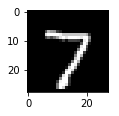

In [17]:
dataiter = iter(test_loader)
images, labels = dataiter.next()



util.displayMNIST(images[0].numpy())

In [18]:
import util

The iterative FGSM attack is within util.py

In [19]:
img = images[0].unsqueeze(0)
label = labels[0].unsqueeze(0)

adv_img, noise, attackSuccessful = util.iterative_FGSM_attack(img, label, net)

In [20]:
if attackSuccessful :
    util.displayMNIST(adv_img[0].numpy())
else:
    print("iterative FGSM is not effective")

iterative FGSM is not effective


As the noise value is not within [0, 1]. Therefore, we add each pixel  with 0.5 to display the effect. 

In [21]:
if attackSuccessful :
    util.displayMNIST(noise[0].numpy()+0.5)

Let's check if the adversarial image produces any similar activation pattern. After flowing the pattern into the monitor, the monitor diagnoses that it has not seen anything similar. 

In [22]:
out, intermediateValues = net.forwardWithIntermediate(adv_img)        
print(out.data)

tensor([[-5.8602, -0.5502, -0.4174,  0.7075, -0.0347, -3.4367, -9.9213, 10.5300,
         -2.3333,  2.3564]])


In [23]:
_, predicted = torch.max(out.data, 1)
#iv = intermediateValues.detach().numpy()
#mat = np.zeros(intermediateValues.shape)
#ivabs = np.greater(iv, mat)

# Only perform analysis when the monitor takes all classes
for exampleIndex in range(intermediateValues.detach().numpy().shape[0]):      
    if not monitor.isPatternContained(intermediateValues.detach().numpy()[exampleIndex,:], predicted.numpy()[exampleIndex]):
        print("Adv example is not within activation pattern")
    else:
        print("Adv example is within activation pattern")


Adv example is within activation pattern


Finally, try to generate adversarial images for each image of the test set, and check the percentage of being out of patterns. 

In [24]:
def performAdversarialExamination(loader, monitor):
    notInNeuronActivationPattern = 0
    totalPerturbed = 0
    for images, labels in loader:
        # print(list(images.size())[0])
        for i in range(list(images.size())[0]):

            adv_img, noise, attackSuccessful = util.iterative_FGSM_attack(images[i].unsqueeze(0), labels[i].unsqueeze(0), net)

            if (attackSuccessful) :
                totalPerturbed = totalPerturbed + 1

                out, intermediateValues = net.forwardWithIntermediate(adv_img)  
                _, predicted = torch.max(out.data, 1)
                # iv = intermediateValues.detach().numpy()
                # mat = np.zeros(intermediateValues.shape)
                # ivabs = np.greater(iv, mat)

                for exampleIndex in range(intermediateValues.shape[0]): 
                    # if not monitor.isOnOffPatternContained(ivabs[exampleIndex,:], predicted.numpy()[exampleIndex]):
                    if not monitor.isPatternContained(intermediateValues.detach().numpy()[exampleIndex,:], predicted.numpy()[exampleIndex]):
                        notInNeuronActivationPattern = notInNeuronActivationPattern +1


    print('not in neuron activation pattern / all total perturbed: {} %'.format(100 * notInNeuronActivationPattern / totalPerturbed))
    print('all total perturbed = '+str(totalPerturbed))

In [25]:
isTestAdv = False
if isTestAdv:
    performAdversarialExamination(test_loader, monitor)

### C. Enlarge the region by allowing perturbation

One may now enlarge the memorized pattern by allowing 1-bit flip (thus out-of-activation will drop), and run it again 

In [26]:
monitor.enlargeSetByOneBitFluctuation(-1)

In [27]:
# We don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    outofActivationPattern = 0
    outofActivationPatternAndResultWrong = 0
    
    total = 0
    for images, labels in test_loader:
        labels = labels.to(device)
        outputs, intermediateValues = net.forwardWithIntermediate(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
                
        # Additional processing for runtime monitoring
        
        predictedNp = predicted.numpy()
        
        result = (predicted == labels)
        res = result.numpy()
               
        # Iterate over each image in the batch
        for exampleIndex in range(intermediateValues.shape[0]):   
            if not monitor.isPatternContained(intermediateValues.numpy()[exampleIndex,:], predicted.numpy()[exampleIndex]):
                outofActivationPattern = outofActivationPattern +1
                if res[exampleIndex] == False :
                    outofActivationPatternAndResultWrong = outofActivationPatternAndResultWrong + 1
          
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
    print('Out-of-activation pattern on the 10000 test images: {} %'.format(100 * outofActivationPattern / total))
    print('Out-of-activation pattern & misclassified / out-of-activation pattern : {} %'.format(100 * outofActivationPatternAndResultWrong / (outofActivationPattern)))
          

Accuracy of the network on the 10000 test images: 98.81 %
Out-of-activation pattern on the 10000 test images: 2.01 %
Out-of-activation pattern & misclassified / out-of-activation pattern : 21.890547263681594 %


In [28]:
print('Out-of-activation pattern & misclassified / mis-classified: {} %'.format(100 * outofActivationPatternAndResultWrong / (total - correct)))


Out-of-activation pattern & misclassified / mis-classified: 36.97478991596638 %


In [29]:
if isTestAdv:
    performAdversarialExamination(test_loader, monitor)

In [30]:
monitor.enlargeSetByOneBitFluctuation(-1)

In [31]:
# We don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    outofActivationPattern = 0
    outofActivationPatternAndResultWrong = 0
    
    total = 0
    for images, labels in test_loader:
        labels = labels.to(device)
        outputs, intermediateValues = net.forwardWithIntermediate(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
                
        # Additional processing for runtime monitoring
        
        predictedNp = predicted.numpy()
        
        result = (predicted == labels)
        res = result.numpy()
               
        # Iterate over each image in the batch
        for exampleIndex in range(intermediateValues.shape[0]):   
            if not monitor.isPatternContained(intermediateValues.numpy()[exampleIndex,:], predicted.numpy()[exampleIndex]):
                outofActivationPattern = outofActivationPattern +1
                if res[exampleIndex] == False :
                    outofActivationPatternAndResultWrong = outofActivationPatternAndResultWrong + 1
          
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
    print('Out-of-activation pattern on the 10000 test images: {} %'.format(100 * outofActivationPattern / total))
    print('Out-of-activation pattern & misclassified / out-of-activation pattern : {} %'.format(100 * outofActivationPatternAndResultWrong / (outofActivationPattern)))
          

Accuracy of the network on the 10000 test images: 98.81 %
Out-of-activation pattern on the 10000 test images: 0.6 %
Out-of-activation pattern & misclassified / out-of-activation pattern : 31.666666666666668 %


In [32]:
print('Out-of-activation pattern & misclassified / mis-classified: {} %'.format(100 * outofActivationPatternAndResultWrong / (total - correct)))


Out-of-activation pattern & misclassified / mis-classified: 15.966386554621849 %


In [33]:
if isTestAdv:
    performAdversarialExamination(test_loader, monitor)

### D. Trigger runtime neuron interval pattern monitoring 

Understand the max value for output of each neuron in the layer under analysis. 

In [34]:

maximumValues = np.zeros([1, sizeOfNeuronsToMonitor])

# We don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    
    total = 0
    for images, labels in test_loader:
        labels = labels.to(device)
        outputs, intermediateValues = net.forwardWithIntermediate(images)
    
    for exampleIndex in range(intermediateValues.shape[0]):   
        maximumValues = np.maximum(intermediateValues.numpy()[exampleIndex,:], maximumValues)
    
    print(maximumValues)

[[ 5.976089   12.64085674 14.45319462 20.14255142 12.10131168  7.20467901
  14.01826191 15.72563648  7.57931471 12.96555805 13.73955441  3.02725601
  12.84442425 12.07688522  0.          8.21488285 19.87310982  0.
  10.62583733  8.91006088 10.26775837 10.06238365 11.35547543 15.94989872
  11.2846899  12.3040657  14.48820591 14.17330456 11.95500755  4.9770484
  17.16381836  0.         13.73954868 12.10352421  3.96824312 11.53234386
  25.40777206 14.69727707  9.12612629  5.32893896]]


Now, prepare two threshold for fine-grained monitor, which is based on further partitioning the >0 domain to 0-33% MaxInTraining, 33%-66% MaxInTraining, and >66% MaxInTraining

In [35]:
threshold1 = (maximumValues*1)/3
threshold2 = (maximumValues*2)/3

In [36]:
runIntervalMonitor = True

from nndependability.rv import nipmonitor
intervalmonitor = nipmonitor.NIP_Monitor(num_classes, sizeOfNeuronsToMonitor, threshold1, threshold2)

Here, we only do it on class 2.

In [37]:
classToAnalyze = 2
# Use below if we want to analyze the complete class
# classToAnalyze = -1

if runIntervalMonitor: 

    with torch.no_grad():
        for images, labels in train_loader:
            labels = labels.to(device)
            outputs, intermediateValues = net.forwardWithIntermediate(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Add the batch of neuron activation patterns to the monitor, with only the 0-th class
            intervalmonitor.addAllNeuronPatternsToClass(intermediateValues.numpy(), predicted.numpy(), labels.numpy(), classToAnalyze)

MemoryError: 

In [38]:

if runIntervalMonitor: 
    
    # We don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        correct = 0
        outofActivationPattern = 0
        outofActivationPatternAndResultWrong = 0

        total = 0
        for images, labels in test_loader:
            labels = labels.to(device)
            outputs, intermediateValues = net.forwardWithIntermediate(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Additional processing for runtime monitoring

            predictedNp = predicted.numpy()

            result = (predicted == labels)
            res = result.numpy()

            # Iterate over each image in the batch
            for exampleIndex in range(intermediateValues.shape[0]): 
                if (classToAnalyze == -1) or (predicted.numpy()[exampleIndex] == classToAnalyze): 
                    if not intervalmonitor.isPatternContained(intermediateValues.numpy()[exampleIndex,:], predicted.numpy()[exampleIndex]):
                        outofActivationPattern = outofActivationPattern +1
                        if res[exampleIndex] == False :
                            outofActivationPatternAndResultWrong = outofActivationPatternAndResultWrong + 1

        print('Result on interval-based monitor ([0,1,2,3]:= [<=0, 0-33%, 33%-66%, >66%] in max training value: ')      
        print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))


MemoryError: 

In [38]:
if classToAnalyze == -1:
        print('Out-of-activation pattern on the 10000 test images: {} %'.format(100 * outofActivationPattern / total))
        print('Out-of-activation pattern & misclassified / out-of-activation pattern : {} %'.format(100 * outofActivationPatternAndResultWrong / (outofActivationPattern)))
else:
        print('Out-of-activation pattern & misclassified / out-of-activation pattern for class '+str(classToAnalyze)+': {} %'.format(100 * outofActivationPatternAndResultWrong / (outofActivationPattern)))


Out-of-activation pattern & misclassified / out-of-activation pattern for class 2: 1.5337423312883436 %


In [39]:
# torch.save(net.state_dict(), 'local/model_MNIST_CNN.ckpt')

#### Acknowledgements 

During the development of this jupyter notebook, I got some code from existing github repositories:

- PyTorch tutorials as in https://pytorch.org/
- https://github.com/Lextal/adv-attacks-pytorch-101/ for implementing iterative FGSM on PyTorch
